In [1]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import itertools
import yfinance as yf
import seaborn as sn
from IPython.core.display import display, HTML

%matplotlib inline

In [2]:
def jupyter_interactive_mode():
    display(HTML(
    '<style>'
    '#notebook { padding-top:0px !important; }'
    '.container { width:100% !important; }'
    '.end_space { min-height:0px !important}'
    '</style'
    ))

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
jupyter_interactive_mode()

## Helper functions to help pull the data and run the analysis

In [4]:
# Function to pull financial data for a ticker using Yahoo Finance's API
def load_financial_data(start_date, end_date, ticker):
    output_file=f'{ticker}-pickle-{start_date}-{end_date}'
    try:
        df = pd.read_pickle(output_file)
        print(f'File data found...reading {ticker} data')
    except FileNotFoundError:
        print(f'File not found...downloading the {ticker} data')
        df = yf.download(ticker, start=start_date, end=end_date)
        df.to_pickle(output_file)
    return df

In [5]:
# Function to run a linear regression analysis using in-sample and out-of sample datasets and return the regression
# model and the predicted target variable using the in sample and out of sample data
def linear_regression(x_train, y_train, x_test, y_test):
    
    # Create a model to fit independent variables to a target variable using ordinary least squares
    regr = linear_model.LinearRegression()
    
    # Train the model using training sets
    regr.fit(x_train, y_train)
    
    # Make predictions based on the model using the training and testing dataset
    y_pred_out = regr.predict(x_test)
    y_pred_in = regr.predict(x_train)
    
    # Print the coefficients of the model
    print('Coefficients: \n', regr.coef_[0])
    
    # Print the Mean Squared Error
    print('Mean Squared Error for in sample data: %.4f' %mean_squared_error(y_train, y_pred_in))
    print('Mean Squared Error for out of sample data: %.4f' %mean_squared_error(y_test, y_pred_out))
    
    # Print the Variance Score
    print('R2 Variance Score for in sample data: %.4f' %r2_score(y_train, y_pred_in))
    print('R2 Variance Score for out of sample data: %.4f' %r2_score(y_test, y_pred_out))
    
    # Plot the outputs for in sample and out of sample data
    fig = plt.figure(figsize=(12,6))
    plt.style.use('bmh')
    layout = (1,2)
    in_sample_ax = plt.subplot2grid(layout, (0,0))
    out_sample_ax = plt.subplot2grid(layout, (0,1))
    in_sample_ax.scatter(y_pred_in, y_train)
    in_sample_ax.plot(y_train, y_train, linewidth=3)
    in_sample_ax.set_xlabel('Y (actual)')
    in_sample_ax.set_ylabel('Y (predicted)')
    in_sample_ax.set_title('In Sample Predicted vs Actual Scatter Plot')
    
    out_sample_ax.scatter(y_pred_out, y_test)
    out_sample_ax.plot(y_test, y_test, linewidth=3)
    out_sample_ax.set_xlabel('Y (actual)')
    out_sample_ax.set_ylabel('Y (predicted)')
    out_sample_ax.set_title('Out of Sample Predicted vs Actual Scatter Plot')
    plt.tight_layout()
    
    return regr, y_pred_in, y_pred_out

In [6]:
# Function to run a LASSO or Ridge regression analysis with a tuning parameter specified and return the model with
# coefficients, RMSE and R^2 values
def regularization_regression(x_train, y_train, x_test, y_test, alpha, regression_type='Ridge'):
    
    # Create a regression model based on specified input (it will default to Ridge if nothing is specified)
    if regression_type == 'Lasso':
        # Create a model to fit independent variables to a target variable using ordinary least squares
        regr = linear_model.Lasso(alpha)
    elif regression_type == 'Ridge':
        regr = linear_model.Ridge(alpha)
    else: # Defaults to using Ridge
        regr = linear_model.Ridge(alpha)
    
    # Train the model using training sets
    regr.fit(x_train, y_train)
    
    # Make predictions based on the model using the training and testing dataset
    y_pred_train = regr.predict(x_train)
    y_pred_test = regr.predict(x_test)
    
    # Calculate the Mean Squared Error
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    
    # Calculate the Variance Score
    r_squared_train = r2_score(y_train, y_pred_train)
    r_squared_test = r2_score(y_test, y_pred_test)
    
    return regr, regr.coef_, r_squared_train, r_squared_test, mse_train, mse_test

In [7]:
# Function to build a feature for momentum based on user defined time period
def momentum(df, period):
    return df.sub(df.shift(period), fill_value=0)

## Pull the data from Yahoo Finance

We begin by pulling daily data for the specified instrument using the Yahoo finance API. The data available only goes back to late 2017. 

In [529]:
# Specify date range and pull data for specific instrument
start_date = pd.datetime(2015, 1, 1)
end_date = pd.datetime(2024, 7, 5)
ticker = ['BCH-USD','ETH-USD','USDT-USD','XRP-USD','BNB-USD','BTC-USD']
data = load_financial_data(start_date, end_date, ticker=ticker)
data = data['Adj Close']

File not found...downloading the ['BCH-USD', 'ETH-USD', 'USDT-USD', 'XRP-USD', 'BNB-USD', 'BTC-USD'] data
[*********************100%***********************]  6 of 6 completed


In [530]:
ticker = ['SPY']
data_SPY = load_financial_data(start_date, end_date, ticker=ticker)
data_SPY = data_SPY[['Adj Close']]
data_SPY.columns = ['SPY']

File not found...downloading the ['SPY'] data
[*********************100%***********************]  1 of 1 completed


In [531]:
data_SPY.head()

,SPY
Date,
2015-01-02,173.704941
2015-01-05,170.567917
2015-01-06,168.961319
2015-01-07,171.066772
2015-01-08,174.102356


In [532]:
def get_returns_volatility(df, vol_range_list=[10], close_px_col='BTC-USD'):
    
    df[f'{close_px_col}_pct_returns'] = df[close_px_col].pct_change()
    for vol_range in vol_range_list:
        df[f'{close_px_col}_volatility_{vol_range}'] = df[f'{close_px_col}_pct_returns'].rolling(vol_range).std()
    
    return df

In [533]:
def calculate_slope(df, column, periods):
    return (df[column] - df[column].shift(int(periods))) / periods

In [534]:
def trend_signal(row):
    if all(row[i] <= row[i+1] for i in range(len(row) - 1)):
        return -1
    elif all(row[i] >= row[i+1] for i in range(len(row) - 1)):
        return 1
    else:
        return 0

def slope_signal(row):
    if all(row[i] <= row[i+1] for i in range(len(row) - 1)):
        return -1
    elif all(row[i] >= row[i+1] for i in range(len(row) - 1)):
        return 1
    else:
        return 0    

In [535]:
def generate_trend_signal(df, mavg_slope_col_list, ticker='BTC-USD'):
    
    def slope_signal(row):
        if all(row[i] <= row[i+1] for i in range(len(row) - 1)):
            return 'downtrend'
        elif all(row[i] >= row[i+1] for i in range(len(row) - 1)):
            return 'uptrend'
        
    df[f'{ticker}_trend_slope_signal'] = df[mavg_slope_col_list].apply(slope_signal, axis=1)

    return df

In [536]:
def sharpe_ratio(df, return_col, trade_col, N=255, rf=0.01):
    
    trade_cond = (df[trade_col].notnull())
    mean = df[trade_cond][return_col].mean() * N -rf
    sigma = df[trade_cond][return_col].std() * np.sqrt(N)
    return mean / sigma

In [537]:
mavg_start = 20
mavg_end = 200
mavg_stepsize = 10

In [538]:
for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
    print(window)

20.0
40.0
60.0
80.0
100.0
120.0
140.0
160.0
180.0
200.0


In [539]:
for end in np.linspace(200, 600, 3):
    print(end)

200.0
400.0
600.0


In [540]:
for end in np.arange(200, 1000, 10):
    print(end)

200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [528]:
for end in np.arange(200, 1000, 50):
    for start in np.arange(10, end, 10):
        for stepsizes in np.arange(1,10,1):
            print(start, end, end/start*stepsizes)

10 200 20.0
10 200 40.0
10 200 60.0
10 200 80.0
10 200 100.0
10 200 120.0
10 200 140.0
10 200 160.0
10 200 180.0
20 200 10.0
20 200 20.0
20 200 30.0
20 200 40.0
20 200 50.0
20 200 60.0
20 200 70.0
20 200 80.0
20 200 90.0
30 200 6.666666666666667
30 200 13.333333333333334
30 200 20.0
30 200 26.666666666666668
30 200 33.333333333333336
30 200 40.0
30 200 46.66666666666667
30 200 53.333333333333336
30 200 60.0
40 200 5.0
40 200 10.0
40 200 15.0
40 200 20.0
40 200 25.0
40 200 30.0
40 200 35.0
40 200 40.0
40 200 45.0
50 200 4.0
50 200 8.0
50 200 12.0
50 200 16.0
50 200 20.0
50 200 24.0
50 200 28.0
50 200 32.0
50 200 36.0
60 200 3.3333333333333335
60 200 6.666666666666667
60 200 10.0
60 200 13.333333333333334
60 200 16.666666666666668
60 200 20.0
60 200 23.333333333333336
60 200 26.666666666666668
60 200 30.0
70 200 2.857142857142857
70 200 5.714285714285714
70 200 8.571428571428571
70 200 11.428571428571429
70 200 14.285714285714286
70 200 17.142857142857142
70 200 20.0
70 200 22.8571428571

280 350 7.5
280 350 8.75
280 350 10.0
280 350 11.25
290 350 1.206896551724138
290 350 2.413793103448276
290 350 3.6206896551724137
290 350 4.827586206896552
290 350 6.0344827586206895
290 350 7.241379310344827
290 350 8.448275862068964
290 350 9.655172413793103
290 350 10.862068965517242
300 350 1.1666666666666667
300 350 2.3333333333333335
300 350 3.5
300 350 4.666666666666667
300 350 5.833333333333334
300 350 7.0
300 350 8.166666666666668
300 350 9.333333333333334
300 350 10.5
310 350 1.1290322580645162
310 350 2.2580645161290325
310 350 3.387096774193549
310 350 4.516129032258065
310 350 5.645161290322581
310 350 6.774193548387098
310 350 7.903225806451614
310 350 9.03225806451613
310 350 10.161290322580646
320 350 1.09375
320 350 2.1875
320 350 3.28125
320 350 4.375
320 350 5.46875
320 350 6.5625
320 350 7.65625
320 350 8.75
320 350 9.84375
330 350 1.0606060606060606
330 350 2.121212121212121
330 350 3.1818181818181817
330 350 4.242424242424242
330 350 5.303030303030303
330 350 6.3

40 500 25.0
40 500 37.5
40 500 50.0
40 500 62.5
40 500 75.0
40 500 87.5
40 500 100.0
40 500 112.5
50 500 10.0
50 500 20.0
50 500 30.0
50 500 40.0
50 500 50.0
50 500 60.0
50 500 70.0
50 500 80.0
50 500 90.0
60 500 8.333333333333334
60 500 16.666666666666668
60 500 25.0
60 500 33.333333333333336
60 500 41.66666666666667
60 500 50.0
60 500 58.333333333333336
60 500 66.66666666666667
60 500 75.0
70 500 7.142857142857143
70 500 14.285714285714286
70 500 21.42857142857143
70 500 28.571428571428573
70 500 35.714285714285715
70 500 42.85714285714286
70 500 50.0
70 500 57.142857142857146
70 500 64.28571428571429
80 500 6.25
80 500 12.5
80 500 18.75
80 500 25.0
80 500 31.25
80 500 37.5
80 500 43.75
80 500 50.0
80 500 56.25
90 500 5.555555555555555
90 500 11.11111111111111
90 500 16.666666666666664
90 500 22.22222222222222
90 500 27.77777777777778
90 500 33.33333333333333
90 500 38.888888888888886
90 500 44.44444444444444
90 500 50.0
100 500 5.0
100 500 10.0
100 500 15.0
100 500 20.0
100 500 25.0

120 600 15.0
120 600 20.0
120 600 25.0
120 600 30.0
120 600 35.0
120 600 40.0
120 600 45.0
130 600 4.615384615384615
130 600 9.23076923076923
130 600 13.846153846153845
130 600 18.46153846153846
130 600 23.076923076923073
130 600 27.69230769230769
130 600 32.30769230769231
130 600 36.92307692307692
130 600 41.53846153846153
140 600 4.285714285714286
140 600 8.571428571428571
140 600 12.857142857142858
140 600 17.142857142857142
140 600 21.428571428571427
140 600 25.714285714285715
140 600 30.0
140 600 34.285714285714285
140 600 38.57142857142857
150 600 4.0
150 600 8.0
150 600 12.0
150 600 16.0
150 600 20.0
150 600 24.0
150 600 28.0
150 600 32.0
150 600 36.0
160 600 3.75
160 600 7.5
160 600 11.25
160 600 15.0
160 600 18.75
160 600 22.5
160 600 26.25
160 600 30.0
160 600 33.75
170 600 3.5294117647058822
170 600 7.0588235294117645
170 600 10.588235294117647
170 600 14.117647058823529
170 600 17.647058823529413
170 600 21.176470588235293
170 600 24.705882352941174
170 600 28.2352941176470

640 650 4.0625
640 650 5.078125
640 650 6.09375
640 650 7.109375
640 650 8.125
640 650 9.140625
10 700 70.0
10 700 140.0
10 700 210.0
10 700 280.0
10 700 350.0
10 700 420.0
10 700 490.0
10 700 560.0
10 700 630.0
20 700 35.0
20 700 70.0
20 700 105.0
20 700 140.0
20 700 175.0
20 700 210.0
20 700 245.0
20 700 280.0
20 700 315.0
30 700 23.333333333333332
30 700 46.666666666666664
30 700 70.0
30 700 93.33333333333333
30 700 116.66666666666666
30 700 140.0
30 700 163.33333333333331
30 700 186.66666666666666
30 700 210.0
40 700 17.5
40 700 35.0
40 700 52.5
40 700 70.0
40 700 87.5
40 700 105.0
40 700 122.5
40 700 140.0
40 700 157.5
50 700 14.0
50 700 28.0
50 700 42.0
50 700 56.0
50 700 70.0
50 700 84.0
50 700 98.0
50 700 112.0
50 700 126.0
60 700 11.666666666666666
60 700 23.333333333333332
60 700 35.0
60 700 46.666666666666664
60 700 58.33333333333333
60 700 70.0
60 700 81.66666666666666
60 700 93.33333333333333
60 700 105.0
70 700 10.0
70 700 20.0
70 700 30.0
70 700 40.0
70 700 50.0
70 700 6

420 750 8.928571428571429
420 750 10.714285714285715
420 750 12.5
420 750 14.285714285714286
420 750 16.071428571428573
430 750 1.744186046511628
430 750 3.488372093023256
430 750 5.232558139534884
430 750 6.976744186046512
430 750 8.720930232558139
430 750 10.465116279069768
430 750 12.209302325581396
430 750 13.953488372093023
430 750 15.69767441860465
440 750 1.7045454545454546
440 750 3.409090909090909
440 750 5.113636363636363
440 750 6.818181818181818
440 750 8.522727272727273
440 750 10.227272727272727
440 750 11.931818181818182
440 750 13.636363636363637
440 750 15.340909090909092
450 750 1.6666666666666667
450 750 3.3333333333333335
450 750 5.0
450 750 6.666666666666667
450 750 8.333333333333334
450 750 10.0
450 750 11.666666666666668
450 750 13.333333333333334
450 750 15.0
460 750 1.6304347826086956
460 750 3.260869565217391
460 750 4.891304347826087
460 750 6.521739130434782
460 750 8.152173913043478
460 750 9.782608695652174
460 750 11.41304347826087
460 750 13.043478260869

790 800 5.063291139240507
790 800 6.075949367088608
790 800 7.088607594936709
790 800 8.10126582278481
790 800 9.113924050632912
10 850 85.0
10 850 170.0
10 850 255.0
10 850 340.0
10 850 425.0
10 850 510.0
10 850 595.0
10 850 680.0
10 850 765.0
20 850 42.5
20 850 85.0
20 850 127.5
20 850 170.0
20 850 212.5
20 850 255.0
20 850 297.5
20 850 340.0
20 850 382.5
30 850 28.333333333333332
30 850 56.666666666666664
30 850 85.0
30 850 113.33333333333333
30 850 141.66666666666666
30 850 170.0
30 850 198.33333333333331
30 850 226.66666666666666
30 850 255.0
40 850 21.25
40 850 42.5
40 850 63.75
40 850 85.0
40 850 106.25
40 850 127.5
40 850 148.75
40 850 170.0
40 850 191.25
50 850 17.0
50 850 34.0
50 850 51.0
50 850 68.0
50 850 85.0
50 850 102.0
50 850 119.0
50 850 136.0
50 850 153.0
60 850 14.166666666666666
60 850 28.333333333333332
60 850 42.5
60 850 56.666666666666664
60 850 70.83333333333333
60 850 85.0
60 850 99.16666666666666
60 850 113.33333333333333
60 850 127.5
70 850 12.142857142857142

270 900 20.0
270 900 23.333333333333336
270 900 26.666666666666668
270 900 30.0
280 900 3.2142857142857144
280 900 6.428571428571429
280 900 9.642857142857142
280 900 12.857142857142858
280 900 16.071428571428573
280 900 19.285714285714285
280 900 22.5
280 900 25.714285714285715
280 900 28.92857142857143
290 900 3.103448275862069
290 900 6.206896551724138
290 900 9.310344827586206
290 900 12.413793103448276
290 900 15.517241379310345
290 900 18.620689655172413
290 900 21.724137931034484
290 900 24.82758620689655
290 900 27.93103448275862
300 900 3.0
300 900 6.0
300 900 9.0
300 900 12.0
300 900 15.0
300 900 18.0
300 900 21.0
300 900 24.0
300 900 27.0
310 900 2.903225806451613
310 900 5.806451612903226
310 900 8.70967741935484
310 900 11.612903225806452
310 900 14.516129032258064
310 900 17.41935483870968
310 900 20.322580645161292
310 900 23.225806451612904
310 900 26.129032258064516
320 900 2.8125
320 900 5.625
320 900 8.4375
320 900 11.25
320 900 14.0625
320 900 16.875
320 900 19.6875

490 950 13.571428571428571
490 950 15.510204081632653
490 950 17.448979591836736
500 950 1.9
500 950 3.8
500 950 5.699999999999999
500 950 7.6
500 950 9.5
500 950 11.399999999999999
500 950 13.299999999999999
500 950 15.2
500 950 17.099999999999998
510 950 1.8627450980392157
510 950 3.7254901960784315
510 950 5.588235294117647
510 950 7.450980392156863
510 950 9.313725490196079
510 950 11.176470588235293
510 950 13.03921568627451
510 950 14.901960784313726
510 950 16.764705882352942
520 950 1.8269230769230769
520 950 3.6538461538461537
520 950 5.480769230769231
520 950 7.3076923076923075
520 950 9.134615384615385
520 950 10.961538461538462
520 950 12.788461538461538
520 950 14.615384615384615
520 950 16.442307692307693
530 950 1.7924528301886793
530 950 3.5849056603773586
530 950 5.377358490566038
530 950 7.169811320754717
530 950 8.962264150943396
530 950 10.754716981132075
530 950 12.547169811320755
530 950 14.339622641509434
530 950 16.132075471698112
540 950 1.7592592592592593
540 

In [541]:
def create_trend_strategy(df, ticker, mavg_start, mavg_end, mavg_stepsize, vol_range_list=[10, 20, 30, 60, 90]):
    
    for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
        df[f'{ticker}_{int(window)}_mavg'] = df[f'{ticker}'].rolling(int(window)).mean()
        df[f'{ticker}_{int(window)}_mavg_slope'] = calculate_slope(df, column=f'{ticker}_{int(window)}_mavg', periods=window)

    df[f'{ticker}_ribbon_thickness'] = df[f'{ticker}_{int(mavg_start)}_mavg'] - df[f'{ticker}_{int(mavg_end)}_mavg']
    df = get_returns_volatility(df, vol_range_list=vol_range_list, close_px_col=ticker)

    ## Ticker Trend Signal and Trade
    mavg_col_list = [f'{ticker}_{int(mavg)}_mavg' for mavg in np.linspace(mavg_start, mavg_end, mavg_stepsize).tolist()]
    mavg_slope_col_list = [f'{ticker}_{int(mavg)}_mavg_slope' for mavg in np.linspace(mavg_start, mavg_end, mavg_stepsize).tolist()]
    df[f'{ticker}_trend_signal'] = df[mavg_col_list].apply(trend_signal, axis=1)
    df[f'{ticker}_trend_signal_diff'] = df[f'{ticker}_trend_signal'].diff().shift(1)
    df[f'{ticker}_trend_trade'] = np.where(df[f'{ticker}_trend_signal_diff'] != 0, df[f'{ticker}'], np.nan)
    df[f'{ticker}_trend_strategy_returns'] = df[f'{ticker}_pct_returns'] * df[f'{ticker}_trend_signal_diff']
    
    ## Ticker Trend Slope Signal and Trade
    df[f'{ticker}_trend_slope_signal'] = df[mavg_slope_col_list].apply(slope_signal, axis=1)
    df[f'{ticker}_trend_slope_signal_diff'] = df[f'{ticker}_trend_slope_signal'].diff().shift(1)
    df[f'{ticker}_trend_slope_trade'] = np.where(df[f'{ticker}_trend_slope_signal_diff'] != 0, df[f'{ticker}'], np.nan)
    df[f'{ticker}_trend_slope_strategy_returns'] = df[f'{ticker}_pct_returns'] * df[f'{ticker}_trend_slope_signal_diff']
    
    ## Drop all null values
    df = df[df[f'{ticker}_{mavg_end}_mavg_slope'].notnull()]
    
    ## Calculate P&L
    df[f'{ticker}_mavg_trend_PnL'] = df[f'{ticker}_trend_signal_diff'] * df[f'{ticker}_trend_trade'] * -1
    df[f'{ticker}_mavg_slope_PnL'] = df[f'{ticker}_trend_slope_signal_diff'] * df[f'{ticker}_trend_slope_trade'] * -1
    
    ## Calculate Cumulative P&L
    df[f'{ticker}_mavg_trend_PnL_cum'] = df[f'{ticker}_mavg_trend_PnL'].cumsum()
    df[f'{ticker}_mavg_slope_PnL_cum'] = df[f'{ticker}_mavg_slope_PnL'].cumsum()
   
    return df

In [542]:
data = create_trend_strategy(data, ticker='BTC-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize)

In [543]:
sharpe_ratio(data, return_col='BTC-USD_trend_strategy_returns', trade_col='BTC-USD_trend_trade')

3.374582859269323

In [544]:
data = create_trend_strategy(data, ticker='ETH-USD', mavg_start=mavg_start, mavg_end=mavg_end, mavg_stepsize=mavg_stepsize)

In [545]:
sharpe_ratio(data, return_col='ETH-USD_trend_strategy_returns', trade_col='ETH-USD_trend_trade')

-5.389557452435514

In [509]:
data[data['ETH-USD_trend_trade'].notnull()]

,BCH-USD,BNB-USD,BTC-USD,ETH-USD,USDT-USD,XRP-USD,BTC-USD_20_mavg,BTC-USD_20_mavg_slope,BTC-USD_40_mavg,BTC-USD_40_mavg_slope,BTC-USD_60_mavg,BTC-USD_60_mavg_slope,BTC-USD_80_mavg,BTC-USD_80_mavg_slope,BTC-USD_100_mavg,BTC-USD_100_mavg_slope,BTC-USD_120_mavg,BTC-USD_120_mavg_slope,BTC-USD_140_mavg,BTC-USD_140_mavg_slope,BTC-USD_160_mavg,BTC-USD_160_mavg_slope,BTC-USD_180_mavg,BTC-USD_180_mavg_slope,BTC-USD_200_mavg,BTC-USD_200_mavg_slope,BTC-USD_ribbon_thickness,BTC-USD_pct_returns,BTC-USD_volatility_10,BTC-USD_volatility_20,BTC-USD_volatility_30,BTC-USD_volatility_60,BTC-USD_volatility_90,BTC-USD_trend_signal,BTC-USD_trend_signal_diff,BTC-USD_trend_trade,BTC-USD_trend_strategy_returns,BTC-USD_trend_slope_signal,BTC-USD_trend_slope_signal_diff,BTC-USD_trend_slope_trade,BTC-USD_trend_slope_strategy_returns,BTC-USD_mavg_trend_PnL,BTC-USD_mavg_slope_PnL,BTC-USD_mavg_trend_PnL_cum,BTC-USD_mavg_slope_PnL_cum,ETH-USD_20_mavg,ETH-USD_20_mavg_slope,ETH-USD_40_mavg,ETH-USD_40_mavg_slope,ETH-USD_60_mavg,ETH-USD_60_mavg_slope,ETH-USD_80_mavg,ETH-USD_80_mavg_slope,ETH-USD_100_mavg,ETH-USD_100_mavg_slope,ETH-USD_120_mavg,ETH-USD_120_mavg_slope,ETH-USD_140_mavg,ETH-USD_140_mavg_slope,ETH-USD_160_mavg,ETH-USD_160_mavg_slope,ETH-USD_180_mavg,ETH-USD_180_mavg_slope,ETH-USD_200_mavg,ETH-USD_200_mavg_slope,ETH-USD_ribbon_thickness,ETH-USD_pct_returns,ETH-USD_volatility_10,ETH-USD_volatility_20,ETH-USD_volatility_30,ETH-USD_volatility_60,ETH-USD_volatility_90,ETH-USD_trend_signal,ETH-USD_trend_signal_diff,ETH-USD_trend_trade,ETH-USD_trend_strategy_returns,ETH-USD_trend_slope_signal,ETH-USD_trend_slope_signal_diff,ETH-USD_trend_slope_trade,ETH-USD_trend_slope_strategy_returns,ETH-USD_mavg_trend_PnL,ETH-USD_mavg_slope_PnL,ETH-USD_mavg_trend_PnL_cum,ETH-USD_mavg_slope_PnL_cum
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-12-31,151.045700,6.164732,3742.700439,133.368256,1.013722,0.352706,3716.196851,-8.378574,3799.982587,-59.974848,4516.531067,-33.410799,4999.479556,-22.060216,5312.042351,-14.552316,5518.855048,-13.859215,5685.894104,-13.139308,5881.888216,-13.963862,5999.123968,-16.275787,6039.658168,-21.553690,-2323.461317,-0.031881,0.041538,0.047283,0.044533,0.046799,0.039136,-1,0.0,NaN,-0.0,0,0.0,NaN,-0.000000,NaN,NaN,NaN,NaN,113.465675,0.270607,110.759602,-2.156100,137.525035,-1.302879,153.881601,-1.621299,167.820471,-2.022431,176.611409,-2.545801,192.327394,-2.379757,218.733544,-2.353862,245.939112,-2.572339,268.942025,-2.264447,-155.476350,-0.046412,0.089890,0.077142,0.071148,0.064725,0.056503,0,1.0,133.368256,-0.046412,0,0.0,NaN,-0.0,-133.368256,NaN,-133.368256,NaN
2019-05-31,445.069946,32.748165,8574.501953,268.113556,1.003473,0.438574,8049.022803,118.206067,6866.962134,56.761994,6296.606966,40.679636,5731.722260,24.753598,5365.682292,14.881798,5076.217887,2.474856,4864.524660,-4.442365,4741.578325,-8.395278,4615.455218,-10.310240,4621.592371,-12.100204,3427.430432,0.030655,0.033947,0.050877,0.047552,0.042284,0.035445,0,0.0,NaN,0.0,1,0.0,NaN,0.000000,NaN,NaN,NaN,NaN,247.812709,4.084235,206.970363,1.331289,194.200767,1.025247,180.344577,0.635990,171.916707,0.485485,163.443343,0.094373,156.890071,-0.175196,154.904978,-0.517547,148.502949,-0.891319,147.642437,-1.250187,100.170272,0.047896,0.034656,0.058379,0.053003,0.047556,0.041088,1,1.0,268.113556,0.047896,1,0.0,NaN,0.0,-268.113556,NaN,-401.481812,NaN
2019-07-19,308.027649,29.078394,10530.732422,221.333420,1.002974,0.320605,11105.982520,57.539880,10530.583716,76.291674,9751.617912,70.545367,9004.750232,57.716273,8256.855430,43.369724,7635.256901,32.138090,7108.090428,19.011893,6696.099329,10.266224,6344.116550,3.861296,6088.369254,0.243555,5017.613265,-0.012727,0.072669,0.065738,0.069106,0.053288,0.050840,1,0.0,NaN,-0.0,0,-1.0,10530.732422,0.012727,NaN,10530.732422,NaN,6726.45752,269.365176,-0.772264,277.087812,1.251192,269.860183,1.627939,252.063974,1.307286,234.682249,1.001048,221.022011,0.811731,208.956624,0.473028,199.772541,0.226870,189.987

In [486]:
mavg_start_SPY = 50
mavg_end_SPY = 200
mavg_stepsize_SPY = 2

In [487]:
for window in np.linspace(mavg_start_SPY, mavg_end_SPY, mavg_stepsize_SPY):
    print(window)
    data_SPY[f'SPY_{window}_mavg'] = data_SPY['SPY'].rolling(int(window)).mean()
#     data_SPY[f'SPY_{window}_mavg_slope'] = (data_SPY[f'SPY_10.0_mavg'] - data_SPY[f'SPY_10.0_mavg'].shift(int(window)))/window
    data_SPY[f'SPY_{window}_mavg_slope'] = calculate_slope(data_SPY, column=f'SPY_{window}_mavg', periods=window)
    
data_SPY['SPY_ribbon_thickness'] = data_SPY[f'SPY_{float(mavg_start_SPY)}_mavg'] - data_SPY[f'SPY_{float(mavg_end_SPY)}_mavg']
data_SPY = get_returns_volatility(data_SPY, vol_range_list=[10, 20, 30, 60, 90], close_px_col='SPY')

## SPY Trend Signal and Trade
SPY_mavg_col_list = [f'SPY_{mavg}_mavg' for mavg in np.linspace(mavg_start_SPY, mavg_end_SPY, mavg_stepsize_SPY).tolist()]
SPY_mavg_slope_col_list = [f'SPY_{mavg}_mavg_slope' for mavg in np.linspace(mavg_start_SPY, mavg_end_SPY, mavg_stepsize_SPY).tolist()]
data_SPY['SPY_trend_signal'] = data_SPY[SPY_mavg_col_list].apply(trend_signal, axis=1)
data_SPY['SPY_trend_signal_diff'] = data_SPY['SPY_trend_signal'].diff().shift(1)
data_SPY['SPY_trend_trade'] = np.where(data_SPY['SPY_trend_signal_diff'] != 0, data_SPY['SPY'], np.nan)
data_SPY['SPY_trend_slope_signal'] = data_SPY[SPY_mavg_slope_col_list].apply(slope_signal, axis=1)
data_SPY['SPY_trend_slope_signal_diff'] = data_SPY['SPY_trend_slope_signal'].diff().shift(1)
data_SPY['SPY_trend_slope_trade'] = np.where(data_SPY['SPY_trend_slope_signal_diff'] != 0, data_SPY['SPY'], np.nan)
data_SPY['SPY_trend_strategy_returns'] = data_SPY[f'SPY_pct_returns'] * data_SPY['SPY_trend_signal_diff']
data_SPY['SPY_trend_slope_strategy_returns'] = data_SPY[f'SPY_pct_returns'] * data_SPY['SPY_trend_slope_signal_diff']
# data_SPY['SPY_trend_trade'] = np.where((np.abs(data_SPY['SPY_ribbon_thickness']) > 2000) &
#                                    (data_SPY['SPY_trend_signal_diff'] != 0), data_SPY['SPY_trend_signal_diff'], np.nan)

50.0
200.0


In [488]:
data.shape

(1475, 85)

In [489]:
data_SPY.shape

(2391, 20)

In [490]:
# data = data.dropna()
# data = data[data.index.get_level_values('Date') >= '2018-12-14']
data_SPY = data_SPY[data_SPY.index.get_level_values('Date') >= '2019-06-14']

In [146]:
data['BTC_mavg_slope_PnL'] = data['BTC_trend_slope_signal_diff'] * data['BTC_trend_slope_trade'] * -1
BTC_cols = [col for col in data.columns if (col.startswith('BTC')) & (col[-5:] == 'slope')]
BTC_cols.append('BTC_trend_slope_signal')
BTC_cols.append('BTC_trend_slope_signal_diff')
BTC_cols.append('BTC_mavg_slope_PnL')
BTC_cols.append('BTC-USD_pct_returns')
BTC_cols.append('BTC_trend_slope_strategy_returns')
cond = (data['BTC_trend_slope_signal_diff'] != 0)
data[cond][BTC_cols]

,BTC_20.0_mavg_slope,BTC_40.0_mavg_slope,BTC_60.0_mavg_slope,BTC_80.0_mavg_slope,BTC_100.0_mavg_slope,BTC_120.0_mavg_slope,BTC_140.0_mavg_slope,BTC_160.0_mavg_slope,BTC_180.0_mavg_slope,BTC_200.0_mavg_slope,BTC_trend_slope_signal,BTC_trend_slope_signal_diff,BTC_mavg_slope_PnL,BTC-USD_pct_returns,BTC_trend_slope_strategy_returns
Date,,,,,,,,,,,,,,,
2019-05-18,61.170172,42.693753,27.264341,16.483743,5.479358,-4.518539,-9.032008,-12.268215,-13.289138,-13.425221,1,1.0,-7271.208008,-0.009898,-0.009898
2019-06-11,60.350048,65.923586,44.925126,31.431225,20.858673,8.175274,-0.055577,-5.006424,-7.638880,-10.152976,0,-1.0,7927.714355,-0.009077,0.009077
2019-06-29,88.074930,76.493098,62.085480,44.892259,31.834422,19.408330,8.762962,1.877472,-2.601485,-5.245149,1,1.0,-11959.371094,-0.036105,-0.036105
2019-07-19,57.539880,76.291674,70.545367,57.716273,43.369724,32.138090,19.011893,10.266224,3.861296,0.243555,0,-1.0,10530.732422,-0.012727,0.012727
2020-12-06,177.515581,133.785440,67.964106,42.834935,32.762307,32.162586,31.513395,23.801160,20.877537,18.336574,1,1.0,-19345.121094,0.009966,0.009966
2020-12-10,138.997422,139.846550,76.730668,46.589589,34.447940,32.770274,33.275234,25.171406,21.695896,19.315451,0,-1.0,18264.992188,-0.015572,0.015572
2020-12-29,201.467417,166.723199,128.406850,78.252639,55.810872,42.202578,40.181434,35.531411,28.430003,25.048870,1,1.0,-27362.437500,0.010250,0.010250
2021-01-29,230.022793,339.553792,231.793034,172.469661,122.988593,90.603626,69.822762,60.253320,51.050717,43.010235,0,-1.0,34316.386719,0.025407,-0.025407
2021-02-18,410.544565,344.193162,311.105310,230.793114,172.640359,132.122064,100.694912,81.408396,69.140418,58.303344,1,1.0,-51679.796875,-0.008998,-0.008998


In [147]:
data['BTC_mavg_trend_PnL'] = data['BTC_trend_signal_diff'] * data['BTC_trend_trade'] * -1
BTC_cols = [col for col in data.columns if (col.startswith('BTC')) & (col[-5:] == 'slope')]
BTC_cols.append('BTC_trend_signal')
BTC_cols.append('BTC_trend_signal_diff')
BTC_cols.append('BTC_mavg_trend_PnL')
BTC_cols.append('BTC-USD_pct_returns')
BTC_cols.append('BTC_trend_strategy_returns')
cond = (data['BTC_trend_trade'].notnull())
data[cond][BTC_cols]

,BTC_20.0_mavg_slope,BTC_40.0_mavg_slope,BTC_60.0_mavg_slope,BTC_80.0_mavg_slope,BTC_100.0_mavg_slope,BTC_120.0_mavg_slope,BTC_140.0_mavg_slope,BTC_160.0_mavg_slope,BTC_180.0_mavg_slope,BTC_200.0_mavg_slope,BTC_trend_signal,BTC_trend_signal_diff,BTC_mavg_trend_PnL,BTC-USD_pct_returns,BTC_trend_strategy_returns
Date,,,,,,,,,,,,,,,
2019-01-04,5.434976,-54.947724,-35.540208,-22.617657,-15.629597,-14.054927,-13.421045,-14.254255,-15.492929,-21.478713,0,1.0,-3857.717529,0.005467,0.005467
2019-01-23,-2.573904,-23.003613,-40.595037,-29.211178,-21.160433,-15.468466,-15.926014,-13.908856,-14.498572,-18.381638,0,-1.0,3585.123047,-0.005397,0.005397
2019-01-24,-4.768423,-20.786736,-40.018391,-29.626463,-21.442181,-15.601559,-15.985359,-13.935981,-14.544468,-18.214695,0,1.0,-3600.865479,0.004391,0.004391
2019-02-08,-13.449155,-4.055824,-30.030317,-33.391504,-25.216034,-18.021829,-16.095759,-14.691124,-15.490786,-16.569252,-1,-1.0,3666.780273,0.078632,-0.078632
2019-02-15,-7.600773,-4.026398,-23.476963,-30.917909,-25.914273,-19.281190,-16.203730,-15.410459,-15.169195,-16.057124,0,1.0,-3620.810791,0.001087,0.001087
2019-06-02,114.966389,58.758622,41.960242,26.272720,16.230351,3.619865,-3.608237,-7.800958,-9.787489,-11.814034,1,1.0,-8742.958008,0.020895,0.020895
2019-07-27,-15.458425,70.191695,65.389341,60.548081,46.329576,35.530621,22.600076,13.220057,6.569006,2.002655,0,-1.0,9477.677734,-0.039779,0.039779
2019-12-24,-20.256459,-29.608147,-18.366390,-25.150694,-21.571299,-7.071933,6.904641,15.400006,21.550920,23.139088,-1,-1.0,7322.532227,-0.004499,0.004499
2020-01-08,5.633972,-28.609282,-22.166763,-22.750434,-25.000579,-14.174567,-0.957520,10.151369,16.055000,20.848287,0,1.0,-8079.862793,-0.010269,-0.010269


In [91]:
data['ETH_mavg_slope_PnL'] = data['ETH_trend_slope_signal_diff'] * data['ETH_trend_slope_trade'] * -1
ETH_cols = [col for col in data.columns if (col.startswith('ETH')) & (col[-5:] == 'slope')]
ETH_cols.append('ETH_trend_slope_signal')
ETH_cols.append('ETH_trend_slope_signal_diff')
ETH_cols.append('ETH_mavg_slope_PnL')
cond = (data['ETH_trend_slope_trade'].notnull())
data[cond][ETH_cols]

,ETH_20.0_mavg_slope,ETH_40.0_mavg_slope,ETH_60.0_mavg_slope,ETH_80.0_mavg_slope,ETH_100.0_mavg_slope,ETH_120.0_mavg_slope,ETH_140.0_mavg_slope,ETH_160.0_mavg_slope,ETH_180.0_mavg_slope,ETH_200.0_mavg_slope,ETH_trend_slope_signal,ETH_trend_slope_signal_diff,ETH_mavg_slope_PnL
Date,,,,,,,,,,,,,
2019-02-19,0.017852,-0.002393,-0.386416,-0.970670,-1.196506,-1.527826,-1.861290,-2.041905,-2.064920,-2.305606,1,1.0,-145.346191
2019-02-22,0.430323,0.022283,-0.308594,-0.905061,-1.149314,-1.489047,-1.801176,-2.029853,-2.022897,-2.278102,0,-1.0,149.092453
2019-04-23,1.392918,0.619081,0.373225,0.267901,-0.190961,-0.396953,-0.854584,-1.202440,-1.518058,-1.523017,1,1.0,-171.447800
2019-05-01,0.539241,0.579888,0.402775,0.381821,-0.087986,-0.296117,-0.675804,-1.084702,-1.396005,-1.472543,0,-1.0,160.818344
2019-05-18,1.096318,0.882168,0.681516,0.464617,0.212612,-0.140031,-0.345114,-0.784354,-1.132615,-1.389323,1,1.0,-234.595230
2019-06-14,1.832933,1.902938,1.146693,0.890576,0.658905,0.324923,0.027937,-0.275435,-0.631087,-1.011668,0,-1.0,264.087463
2019-07-06,1.972153,1.969633,1.764018,1.232823,0.920258,0.663850,0.344131,0.062400,-0.294252,-0.607600,1,1.0,-287.547119
2019-07-10,2.277085,1.831359,1.859426,1.273971,0.972829,0.731641,0.394127,0.120013,-0.237055,-0.539031,0,-1.0,290.002319
2020-08-18,6.696517,2.341879,1.361534,1.353252,0.760131,0.668565,0.508656,0.306165,0.299979,0.268360,1,1.0,-423.669312


In [92]:
data['ETH_mavg_trend_PnL'] = data['ETH_trend_signal_diff'] * data['ETH_trend_trade'] * -1
ETH_cols = [col for col in data.columns if (col.startswith('ETH')) & (col[-5:] == 'slope')]
ETH_cols.append('ETH_trend_signal')
ETH_cols.append('ETH_trend_signal_diff')
ETH_cols.append('ETH_mavg_trend_PnL')
cond = (data['ETH_trend_trade'].notnull())
data[cond][ETH_cols]

,ETH_20.0_mavg_slope,ETH_40.0_mavg_slope,ETH_60.0_mavg_slope,ETH_80.0_mavg_slope,ETH_100.0_mavg_slope,ETH_120.0_mavg_slope,ETH_140.0_mavg_slope,ETH_160.0_mavg_slope,ETH_180.0_mavg_slope,ETH_200.0_mavg_slope,ETH_trend_signal,ETH_trend_signal_diff,ETH_mavg_trend_PnL
Date,,,,,,,,,,,,,
2018-12-31,0.270607,-2.156100,-1.302879,-1.621299,-2.022431,-2.545801,-2.379757,-2.353862,-2.572339,-2.264447,0,1.0,-133.368256
2019-05-31,4.084235,1.331289,1.025247,0.635990,0.485485,0.094373,-0.175196,-0.517547,-0.891319,-1.250187,1,1.0,-268.113556
2019-07-19,-0.772264,1.251192,1.627939,1.307286,1.001048,0.811731,0.473028,0.226870,-0.108887,-0.421561,0,-1.0,221.333420
2019-11-25,-0.157735,-0.200376,-0.280661,-0.631374,-0.666042,-0.334396,-0.050415,0.245389,0.364230,0.357726,-1,-1.0,146.476532
2019-11-28,-0.531005,-0.234541,-0.265505,-0.598844,-0.684026,-0.360777,-0.093295,0.212724,0.340122,0.356635,0,1.0,-151.717575
2019-12-06,-1.470428,-0.284770,-0.224328,-0.489345,-0.672514,-0.431358,-0.164270,0.101997,0.277962,0.330999,-1,-1.0,149.194443
2020-01-16,0.297255,-0.792628,-0.654439,-0.378089,-0.496573,-0.584195,-0.432858,-0.257529,-0.086829,0.070351,0,1.0,-164.391006
2020-09-05,0.976124,3.797531,2.065624,1.497464,1.169391,0.834264,0.738007,0.536248,0.361452,0.337253,1,1.0,-335.260071
2020-09-09,-0.630053,3.598952,2.129489,1.513699,1.225233,0.863493,0.767150,0.574717,0.387760,0.342475,0,-1.0,351.110016


In [93]:
data_SPY['SPY_mavg_trend_PnL'] = data_SPY['SPY_trend_signal_diff'] * data_SPY['SPY_trend_trade'] * -1
SPY_cols = [col for col in data_SPY.columns if (col.startswith('SPY')) & (col[-5:] == 'slope')]
SPY_cols.append('SPY_trend_signal')
SPY_cols.append('SPY_trend_signal_diff')
SPY_cols.append('SPY_mavg_trend_PnL')
cond = (data_SPY['SPY_trend_trade'].notnull())
data_SPY[cond][SPY_cols]

,SPY_50.0_mavg_slope,SPY_200.0_mavg_slope,SPY_trend_signal,SPY_trend_signal_diff,SPY_mavg_trend_PnL
Date,,,,,
2020-04-01,-0.345133,0.134891,-1,-2.0,462.065369
2020-07-07,0.417896,0.112694,1,2.0,-591.610596
2022-03-17,-0.417669,0.361597,-1,-2.0,849.671875
2023-01-27,0.318034,-0.234054,1,2.0,-794.175415


In [168]:
# Calculate the mean and standard deviation of the strategy returns
# mean_strategy_return = data['strategy_return'].mean()
# std_strategy_return = data['strategy_return'].std()

# Calculate annualized Sharpe Ratio (assuming 252 trading days in a year)
N = 255 #255 trading days in a year
rf =0.05 #1% risk free rate
cond = (data['BTC_trend_trade'].notnull())
sharpes = sharpe_ratio(data[cond]['BTC_trend_strategy_returns'], N, rf)

In [383]:
data.head()

,BCH-USD,BNB-USD,BTC-USD,ETH-USD,USDT-USD,XRP-USD,BTC-USD_20_mavg,BTC-USD_20_mavg_slope,BTC-USD_40_mavg,BTC-USD_40_mavg_slope,BTC-USD_60_mavg,BTC-USD_60_mavg_slope,BTC-USD_80_mavg,BTC-USD_80_mavg_slope,BTC-USD_100_mavg,BTC-USD_100_mavg_slope,BTC-USD_120_mavg,BTC-USD_120_mavg_slope,BTC-USD_140_mavg,BTC-USD_140_mavg_slope,BTC-USD_160_mavg,BTC-USD_160_mavg_slope,BTC-USD_180_mavg,BTC-USD_180_mavg_slope,BTC-USD_200_mavg,BTC-USD_200_mavg_slope,BTC-USD_ribbon_thickness,BTC-USD_pct_returns,BTC-USD_volatility_10,BTC-USD_volatility_20,BTC-USD_volatility_30,BTC-USD_volatility_60,BTC-USD_volatility_90,BTC-USD_trend_signal,BTC-USD_trend_signal_diff,BTC-USD_trend_trade,BTC-USD_trend_strategy_returns,BTC-USD_trend_slope_signal,BTC-USD_trend_slope_signal_diff,BTC-USD_trend_slope_trade,BTC-USD_trend_slope_strategy_returns,BTC-USD_mavg_trend_PnL,BTC-USD_mavg_slope_PnL
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-02-12,280.857941,327.944611,49958.222656,2658.115967,1.000279,0.531897,43758.903711,28.626074,43472.642969,38.778835,43305.141862,110.545926,42697.066260,150.223033,41475.278242,131.510280,39988.764095,98.444700,38168.726716,73.292376,36688.144958,52.267180,35523.847190,43.250951,34899.764219,42.250486,8859.139492,0.034462,0.016595,0.017027,0.020575,0.024178,0.025206,1,0.0,NaN,0.000000,0,0.0,NaN,0.0,NaN,NaN
2024-02-13,270.852081,324.868225,49742.441406,2642.185303,1.000592,0.524835,44242.172070,63.046611,43611.705957,38.265955,43435.353255,108.991035,42846.386865,150.207734,41622.209102,132.406578,40165.622217,99.766903,38336.763797,74.566188,36838.077490,53.293333,35652.057693,43.900785,35001.880195,42.457999,9240.291875,-0.004319,0.016574,0.017353,0.019888,0.023912,0.024343,1,1.0,49742.441406,-0.004319,0,0.0,NaN,-0.0,-49742.441406,NaN
2024-02-14,281.261658,334.245972,51826.695312,2777.902344,1.000932,0.538401,44836.816406,103.351035,43803.306055,38.878726,43595.129557,107.813870,43025.731543,150.693461,41790.102344,133.517465,40360.713444,101.284002,38518.720787,75.930627,36997.993115,54.380239,35795.264019,44.643230,35114.229082,42.721978,9722.587324,0.041901,0.016160,0.018296,0.020856,0.024426,0.024114,1,0.0,NaN,0.000000,0,0.0,NaN,0.0,NaN,NaN
2024-02-15,270.665924,354.710815,51938.554688,2824.378906,1.000944,0.562755,45342.900586,134.086055,44002.040039,39.637683,43771.361068,107.129862,43209.286377,151.214691,41955.052266,134.550139,40557.465218,102.923541,38696.699414,77.200844,37160.698743,55.495016,35938.832628,45.401727,35227.545312,43.005049,10115.355273,0.002158,0.016111,0.016599,0.020813,0.024216,0.024100,1,0.0,NaN,0.000000,0,0.0,NaN,0.0,NaN,NaN
2024-02-16,274.819977,360.890381,52160.203125,2803.691406,1.000652,0.564960,45844.908008,163.744033,44207.467676,40.953367,43930.305469,105.916787,43388.400342,151.588708,42120.101523,135.558115,40752.801855,104.642144,38877.045717,78.483587,37324.852026,56.610959,36083.113845,46.149177,35342.195771,43.319288,10502.712236,0.004268,0.016600,0.016648,0.020599,0.023967,0.024096,1,0.0,NaN,0.000000,0,0.0,NaN,0.0,NaN,NaN


In [546]:
print(f"BTC-USD_mavg_trend_PnL: {data['BTC-USD_mavg_trend_PnL'].sum()}")
cond = (data['BTC-USD_trend_signal_diff'] != 0)
print(f"BTC-USD Trend Sharpe Ratio: {sharpe_ratio(data, return_col='BTC-USD_trend_strategy_returns', trade_col='BTC-USD_trend_trade')}")
print(f"BTC-USD_mavg_slope_PnL: {data['BTC-USD_mavg_slope_PnL'].sum()}")
cond = (data['BTC-USD_trend_slope_signal_diff'] != 0)
print(f"BTC-USD Trend Slope Sharpe Ratio: {sharpe_ratio(data, return_col='BTC-USD_trend_slope_strategy_returns', trade_col='BTC-USD_trend_slope_trade')}")

BTC-USD_mavg_trend_PnL: 41847.420166015625
BTC-USD Trend Sharpe Ratio: 3.012530231235686
BTC-USD_mavg_slope_PnL: 540.89501953125
BTC-USD Trend Slope Sharpe Ratio: 5.322472839882682


In [547]:
print(f"ETH-USD_mavg_trend_PnL: {data['ETH-USD_mavg_trend_PnL'].sum()}")
cond = (data['ETH-USD_trend_signal_diff'] != 0)
print(f"ETH-USD Trend Sharpe Ratio: {sharpe_ratio(data, return_col='ETH-USD_trend_strategy_returns', trade_col='ETH-USD_trend_trade')}")
print(f"ETH-USD_mavg_slope_PnL: {data['ETH-USD_mavg_slope_PnL'].sum()}")
cond = (data['ETH-USD_trend_slope_signal_diff'] != 0)
print(f"ETH-USD Trend Slope Sharpe Ratio: {sharpe_ratio(data, return_col='ETH-USD_trend_slope_strategy_returns', trade_col='ETH-USD_trend_slope_trade')}")

ETH-USD_mavg_trend_PnL: 3027.328887939453
ETH-USD Trend Sharpe Ratio: -5.389557452435514
ETH-USD_mavg_slope_PnL: -1182.3240966796875
ETH-USD Trend Slope Sharpe Ratio: 4.26345968598999


In [403]:
[col for col in data_SPY.columns if (col.startswith('SPY')) & (col[-4:] == 'mavg')]

['SPY_50.0_mavg', 'SPY_200.0_mavg']

In [404]:
data_SPY.loc[data_SPY.index >= '2020-03-01'][['SPY','SPY_50.0_mavg','SPY_200.0_mavg','SPY_trend_signal','SPY_trend_signal_diff','SPY_mavg_trend_PnL','SPY_ribbon_thickness']].head(500)

,SPY,SPY_50.0_mavg,SPY_200.0_mavg,SPY_trend_signal,SPY_trend_signal_diff,SPY_mavg_trend_PnL,SPY_ribbon_thickness
Date,,,,,,,
2020-03-02,288.411285,303.908506,282.386062,1,0.0,NaN,21.522444
2020-03-03,280.153290,303.576574,282.463708,1,0.0,NaN,21.112866
2020-03-04,291.929016,303.455831,282.608788,1,0.0,NaN,20.847043
2020-03-05,282.224792,303.114874,282.714038,1,0.0,NaN,20.400836
2020-03-06,277.559296,302.671465,282.784188,1,0.0,NaN,19.887276
2020-03-09,255.883453,301.794352,282.750006,1,0.0,NaN,19.044346
2020-03-10,269.124146,301.150140,282.798077,1,0.0,NaN,18.352063
2020-03-11,256.004761,300.245033,282.777609,1,0.0,NaN,17.467424
2020-03-12,231.510971,298.883269,282.646766,1,0.0,NaN,16.236503


In [45]:
data.loc[data.index >= '2022-05-01'][['BTC-USD','BTC_20.0_mavg','BTC_40.0_mavg','BTC_60.0_mavg','BTC_80.0_mavg','BTC_100.0_mavg','BTC_120.0_mavg','BTC_140.0_mavg',
                                      'BTC_160.0_mavg','BTC_180.0_mavg','BTC_200.0_mavg','BTC_trend_signal','BTC_trend_signal_diff','BTC_mavg_trend_PnL','BTC_ribbon_thickness']].head(500)

,BTC-USD,BTC_20.0_mavg,BTC_40.0_mavg,BTC_60.0_mavg,BTC_80.0_mavg,BTC_100.0_mavg,BTC_120.0_mavg,BTC_140.0_mavg,BTC_160.0_mavg,BTC_180.0_mavg,BTC_200.0_mavg,BTC_trend_signal,BTC_trend_signal_diff,BTC_mavg_trend_PnL,BTC_ribbon_thickness
Date,,,,,,,,,,,,,,,
2022-05-01,38469.093750,39861.794727,42281.192480,41570.054883,41372.391846,40950.883008,41255.996680,42239.476283,43607.096069,45666.554188,47255.117617,0,0.0,NaN,-7393.322891
2022-05-02,38529.328125,39781.901953,42172.101758,41504.680534,41323.909229,40985.873789,41182.530924,42180.846624,43488.097656,45530.772418,47161.156641,0,0.0,NaN,-7379.254687
2022-05-03,37750.453125,39611.088086,42016.839746,41481.561328,41267.734033,41000.610273,41109.967057,42117.545340,43372.285327,45399.095877,47041.939160,0,0.0,NaN,-7430.851074
2022-05-04,39698.371094,39599.230859,41900.580762,41486.524414,41236.494727,41031.050703,41058.307031,42051.842829,43262.433398,45280.055295,46935.970117,0,0.0,NaN,-7336.739258
2022-05-05,36575.140625,39400.314648,41702.438574,41455.777018,41161.347510,41027.262070,41000.024837,41972.626507,43156.216992,45141.431185,46811.077734,0,0.0,NaN,-7410.763086
2022-05-06,36040.921875,39181.136523,41432.949316,41422.091732,41054.668994,41019.150078,40940.691439,41900.046345,43038.878516,44989.841927,46681.151953,0,0.0,NaN,-7500.015430
2022-05-07,35501.953125,38970.386523,41142.298047,41368.169792,40948.920166,41002.787266,40890.225195,41818.997600,42902.962866,44811.703733,46537.351758,0,0.0,NaN,-7566.965234
2022-05-08,34059.265625,38632.039062,40807.136426,41236.108789,40867.935840,40965.536602,40826.269564,41728.656529,42754.542236,44628.856163,46377.683906,0,0.0,NaN,-7745.644844
2022-05-09,30296.953125,38071.749219,40387.993652,41083.766992,40746.260547,40887.124336,40729.480827,41610.204213,42587.614282,44436.087956,46218.117813,0,0.0,NaN,-8146.368594


In [425]:
data.loc[data['BTC-USD_trend_trade'].notnull()][['BTC-USD','BTC-USD_20_mavg','BTC-USD_40_mavg','BTC-USD_60_mavg','BTC-USD_80_mavg','BTC-USD_100_mavg','BTC-USD_120_mavg','BTC-USD_140_mavg',
                                      'BTC-USD_160_mavg','BTC-USD_180_mavg','BTC-USD_200_mavg','BTC-USD_trend_signal','BTC-USD_trend_signal_diff','BTC-USD_mavg_trend_PnL','BTC-USD_ribbon_thickness']].head(500)

,BTC-USD,BTC-USD_20_mavg,BTC-USD_40_mavg,BTC-USD_60_mavg,BTC-USD_80_mavg,BTC-USD_100_mavg,BTC-USD_120_mavg,BTC-USD_140_mavg,BTC-USD_160_mavg,BTC-USD_180_mavg,BTC-USD_200_mavg,BTC-USD_trend_signal,BTC-USD_trend_signal_diff,BTC-USD_mavg_trend_PnL,BTC-USD_ribbon_thickness
Date,,,,,,,,,,,,,,,
2016-06-14,685.559021,570.274290,510.903893,489.496478,472.586758,461.202036,455.058064,444.641283,440.576641,440.186781,436.742993,1,1.0,-685.559021,133.531297
2016-07-16,660.767029,662.098407,663.380252,608.652731,569.819373,543.119368,522.395957,507.477184,495.354417,483.181532,477.484054,0,-1.0,660.767029,184.614353
2016-07-31,624.681030,658.834656,657.435605,654.186517,608.394911,577.421628,552.500390,533.168120,519.108036,505.730637,493.999449,1,1.0,-624.681030,164.835207
2016-08-02,547.465027,650.570554,655.776704,654.962701,611.424861,579.870628,555.095299,535.457184,521.033324,507.920604,495.794949,0,-1.0,547.465027,154.775605
2017-01-03,1043.839966,896.643796,828.998999,794.361700,764.206813,735.087031,714.071009,695.104778,682.554332,680.045185,679.191241,1,1.0,-1043.839966,217.452554
2017-01-25,901.541992,878.058447,902.478996,856.870131,824.700512,795.850000,766.864775,744.234429,724.352587,709.033028,704.099646,0,-1.0,901.541992,173.958802
2017-02-05,1027.339966,941.026901,933.444324,896.040733,859.614050,830.410330,799.706867,772.324578,751.263943,732.131389,721.004286,1,1.0,-1027.339966,220.022616
2017-02-18,1054.420044,1013.587900,947.163399,947.906514,905.165562,870.744349,841.691791,810.998671,785.397469,764.006699,745.713300,0,-1.0,1054.420044,267.874600
2017-02-21,1115.300049,1031.754999,965.985399,958.278932,916.881525,881.940889,852.316992,821.069536,794.241106,772.349988,753.330615,1,1.0,-1115.300049,278.424384


In [426]:
data_Pnl = data.loc[data['BTC-USD_trend_trade'].notnull()][['BTC-USD','BTC-USD_20_mavg','BTC-USD_40_mavg','BTC-USD_60_mavg','BTC-USD_80_mavg','BTC-USD_100_mavg','BTC-USD_120_mavg','BTC-USD_140_mavg',
                                      'BTC-USD_160_mavg','BTC-USD_180_mavg','BTC-USD_200_mavg','BTC-USD_trend_signal','BTC-USD_trend_signal_diff','BTC-USD_mavg_trend_PnL','BTC-USD_ribbon_thickness']].head(500)

In [428]:
data_Pnl['BTC-USD_mavg_trend_PnL_cum'] = data_Pnl['BTC-USD_mavg_trend_PnL'].cumsum()

In [455]:
data[data['BTC-USD_trend_trade'].notnull()].head(100)

,BCH-USD,BNB-USD,BTC-USD,ETH-USD,USDT-USD,XRP-USD,BTC-USD_20_mavg,BTC-USD_20_mavg_slope,BTC-USD_40_mavg,BTC-USD_40_mavg_slope,BTC-USD_60_mavg,BTC-USD_60_mavg_slope,BTC-USD_80_mavg,BTC-USD_80_mavg_slope,BTC-USD_100_mavg,BTC-USD_100_mavg_slope,BTC-USD_120_mavg,BTC-USD_120_mavg_slope,BTC-USD_140_mavg,BTC-USD_140_mavg_slope,BTC-USD_160_mavg,BTC-USD_160_mavg_slope,BTC-USD_180_mavg,BTC-USD_180_mavg_slope,BTC-USD_200_mavg,BTC-USD_200_mavg_slope,BTC-USD_ribbon_thickness,BTC-USD_pct_returns,BTC-USD_volatility_10,BTC-USD_volatility_20,BTC-USD_volatility_30,BTC-USD_volatility_60,BTC-USD_volatility_90,BTC-USD_trend_signal,BTC-USD_trend_signal_diff,BTC-USD_trend_trade,BTC-USD_trend_strategy_returns,BTC-USD_trend_slope_signal,BTC-USD_trend_slope_signal_diff,BTC-USD_trend_slope_trade,BTC-USD_trend_slope_strategy_returns,BTC-USD_mavg_trend_PnL,BTC-USD_mavg_slope_PnL,BTC-USD_mavg_trend_PnL_cum,BTC-USD_mavg_slope_PnL_cum
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-14,NaN,NaN,685.559021,NaN,NaN,NaN,570.274290,5.937040,510.903893,1.915857,489.496478,1.147947,472.586758,0.800253,461.202036,0.489181,455.058064,0.607643,444.641283,0.737004,440.576641,0.820299,440.186781,0.852415,436.742993,0.861472,133.531297,-0.026714,0.040305,0.038803,0.034221,0.026612,0.022485,1,1.0,685.559021,-0.026714,0,0.0,NaN,-0.0,-685.559021,NaN,-685.559021,NaN
2016-07-16,NaN,NaN,660.767029,NaN,NaN,NaN,662.098407,-0.128185,663.380252,4.678044,608.652731,2.875226,569.819373,1.861624,543.119368,1.312706,522.395957,0.959410,507.477184,0.919949,495.354417,0.977754,483.181532,0.928826,477.484054,0.916186,184.614353,-0.003751,0.026072,0.031090,0.041428,0.040755,0.034217,0,-1.0,660.767029,0.003751,0,0.0,NaN,-0.0,660.767029,NaN,-24.791992,NaN
2016-07-31,NaN,NaN,624.681030,NaN,NaN,NaN,658.834656,0.139905,657.435605,2.452035,654.186517,3.389538,608.394911,2.232172,577.421628,1.668444,552.500390,1.136972,533.168120,0.985063,519.108036,1.026279,505.730637,1.006880,493.999449,0.925823,164.835207,-0.046357,0.016811,0.016025,0.024607,0.038181,0.034299,1,1.0,624.681030,-0.046357,0,0.0,NaN,-0.0,-624.681030,NaN,-649.473022,NaN
2016-08-02,NaN,NaN,547.465027,NaN,NaN,NaN,650.570554,-0.520615,655.776704,2.217592,654.962701,3.328913,611.424861,2.259788,579.870628,1.681514,555.095299,1.154109,535.457184,0.988445,521.033324,1.023203,507.920604,1.012289,495.794949,0.927587,154.775605,-0.096998,0.032758,0.025996,0.027077,0.039819,0.036056,0,-1.0,547.465027,0.096998,0,0.0,NaN,-0.0,547.465027,NaN,-102.007996,NaN
2017-01-03,NaN,NaN,1043.839966,NaN,NaN,NaN,896.643796,6.764480,828.998999,3.239609,794.361700,2.676356,764.206813,2.041312,735.087031,1.117916,714.071009,0.990947,695.104778,1.022550,682.554332,1.055026,680.045185,1.161573,679.191241,1.184649,217.452554,0.021620,0.018915,0.022383,0.019904,0.017503,0.018598,1,1.0,1043.839966,0.021620,0,0.0,NaN,0.0,-1043.839966,NaN,-1145.847961,NaN
2017-01-25,NaN,NaN,901.541992,NaN,NaN,NaN,878.058447,-2.442055,902.478996,3.888924,856.870131,3.000179,824.700512,2.508698,795.850000,1.835007,766.864775,1.207072,744.234429,1.193985,724.352587,1.170992,709.033028,1.145884,704.099646,1.171821,173.958802,0.009919,0.033919,0.048895,0.051680,0.038407,0.033639,0,-1.0,901.541992,-0.009919,0,0.0,NaN,0.0,901.541992,NaN,-244.305969,NaN
2017-02-05,NaN,NaN,1027.339966,NaN,NaN,NaN,941.026901,0.758258,933.444324,3.691514,896.040733,3.211129,859.614050,2.708753,830.410330,2.188121,799.706867,1.445334,772.324578,1.304983,751.263943,1.268772,732.131389,1.201525,721.004286,1.193447,220.022616,-0.014920,0.018982,0.026813,0.036176,0.038896,0.032757,1,1.0,1027.339966,-0.014920,0,0.0,NaN,-0.0,-1027.339966,NaN,-1271.645935,NaN
2017-02-18,NaN,NaN,1054.420044,NaN,NaN,NaN,1013.587900,6.642450,947.163399,2.099892,947.906514,3.540491,905.165562,2.994202,870.744349,2.500621,841.691791,1.849465,810.998671,1.480764,785.397469,1.389574,764.006699,1.312791,745.713300,1.249592,267.874600,0.007847,0.024841,0.022608,0.020445,0.040139,0.033144,0,-1.0,1054.420044,-0.007847,0,0.0,NaN,0.0,1054

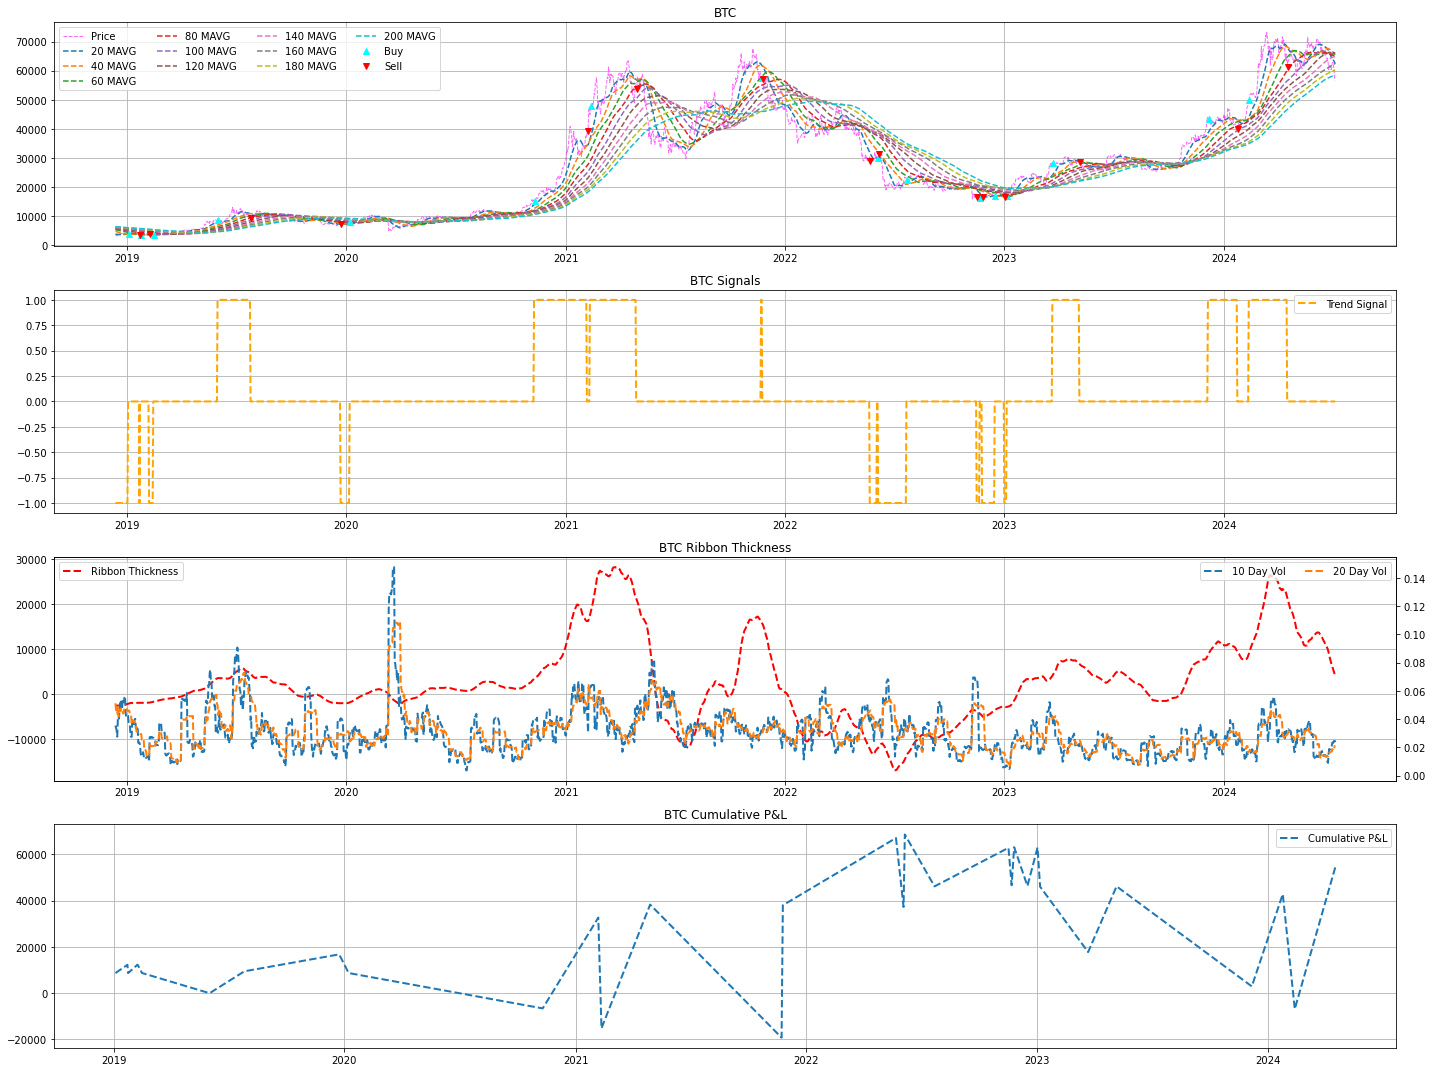

In [548]:
fig = plt.figure(figsize=(20,15))
# plt.style.use('bmh')
layout = (4,2)
mavg_ax = plt.subplot2grid(layout, (0,0), colspan=2)
ribbon_vol_ax = plt.subplot2grid(layout, (2,0), colspan=2)
signal_ax = plt.subplot2grid(layout, (1,0), colspan=2)
pnl_ax = plt.subplot2grid(layout, (3,0), colspan=2)
# trade_ax = plt.subplot2grid(layout, (1,1))

# _ = mavg_ax.plot(data.index, data['BTC-USD_short_mavg'], label='Short MAVG', linestyle='--', color='blue')
# _ = mavg_ax.plot(data.index, data['BTC-USD_long_mavg'], label='Long MAVG', linestyle='--', color='orange')
# _ = ribbon_ax.plot(data.index, data['BTC-USD_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='magenta', linewidth=2)
_ = mavg_ax.plot(data.index, data['BTC-USD'], label='Price', linestyle='--', color='magenta', linewidth=1, alpha=0.6)
for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
    _ = mavg_ax.plot(data.index, data[f'BTC-USD_{int(window)}_mavg'], label=f'{int(window)} MAVG', linestyle='--')
    
buy_cond = (data['BTC-USD_trend_signal_diff'] == 1)
sell_cond = (data['BTC-USD_trend_signal_diff'] == -1)
_ = mavg_ax.plot(data[buy_cond].index, data[buy_cond]['BTC-USD_trend_trade'], label='Buy', linestyle='', color='cyan', linewidth=50, marker='^')
_ = mavg_ax.plot(data[sell_cond].index, data[sell_cond]['BTC-USD_trend_trade'], label='Sell', linestyle='', color='red', linewidth=50, marker='v')
    
# _ = slope_ax.plot(data.index, data['BTC-USD'], label='Price', linestyle='--', color='magenta', linewidth=2, alpha=0.6)
# slope_ax2 = slope_ax.twinx()
# for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
#     _ = slope_ax2.plot(data.index, data[f'BTC-USD_{window}_mavg_slope'], label=f'{window} MAVG Slope', linestyle='--')

_ = signal_ax.plot(data.index, data['BTC-USD_trend_signal'], label='Trend Signal', linestyle='--', color='orange', linewidth=2)
# _ = signal_ax.plot(data.index, data['BTC-USD_trend_slope_signal'], label='Trend Slope Signal', linestyle='--', color='green', linewidth=2)#, marker='v')

_ = ribbon_vol_ax.plot(data.index, data['BTC-USD_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red', linewidth=2)
ribbon_vol_ax2 = ribbon_vol_ax.twinx()
_ = ribbon_vol_ax2.plot(data.index, data['BTC-USD_volatility_10'], label='10 Day Vol', linestyle='--', linewidth=2)
_ = ribbon_vol_ax2.plot(data.index, data['BTC-USD_volatility_20'], label='20 Day Vol', linestyle='--', linewidth=2)

pnl_cond = (data['BTC-USD_trend_trade'].notnull())
_ = pnl_ax.plot(data[pnl_cond].index, data[pnl_cond]['BTC-USD_mavg_trend_PnL_cum'], label='Cumulative P&L', linestyle='--', linewidth=2)

# _ = trade_ax.plot(data.index, data['BTC-USD'], label='Price', linestyle='--', color='magenta', linewidth=2)
# buy_cond = (data['BTC-USD_trend_slope_signal'] == 1)
# sell_cond = (data['BTC-USD_trend_slope_signal'] == -1)
# _ = slope_ax.plot(data[buy_cond].index, data[buy_cond]['BTC-USD_trend_slope_trade'], label='Buy', linestyle='', color='red', linewidth=25, marker='^')
# _ = slope_ax.plot(data[sell_cond].index, data[sell_cond]['BTC-USD_trend_slope_trade'], label='Sell', linestyle='', color='green', linewidth=25, marker='v')

_ = mavg_ax.grid()
_ = mavg_ax.legend(ncol=4)
_ = mavg_ax.set_title('BTC')

# _ = slope_ax.grid()
# _ = slope_ax.legend(ncol=4, loc='upper left')
# _ = slope_ax2.legend(ncol=4, loc='upper right')
# _ = slope_ax.set_title('BTC Trend Signal')

_ = signal_ax.grid()
_ = signal_ax.legend(ncol=4)
_ = signal_ax.set_title('BTC Signals')

_ = ribbon_vol_ax.grid()
_ = ribbon_vol_ax.legend(ncol=4, loc='upper left')
_ = ribbon_vol_ax2.legend(ncol=4, loc='upper right')
_ = ribbon_vol_ax.set_title('BTC Ribbon Thickness')

_ = pnl_ax.grid()
_ = pnl_ax.legend(ncol=4)
_ = pnl_ax.set_title('BTC Cumulative P&L')

plt.tight_layout()

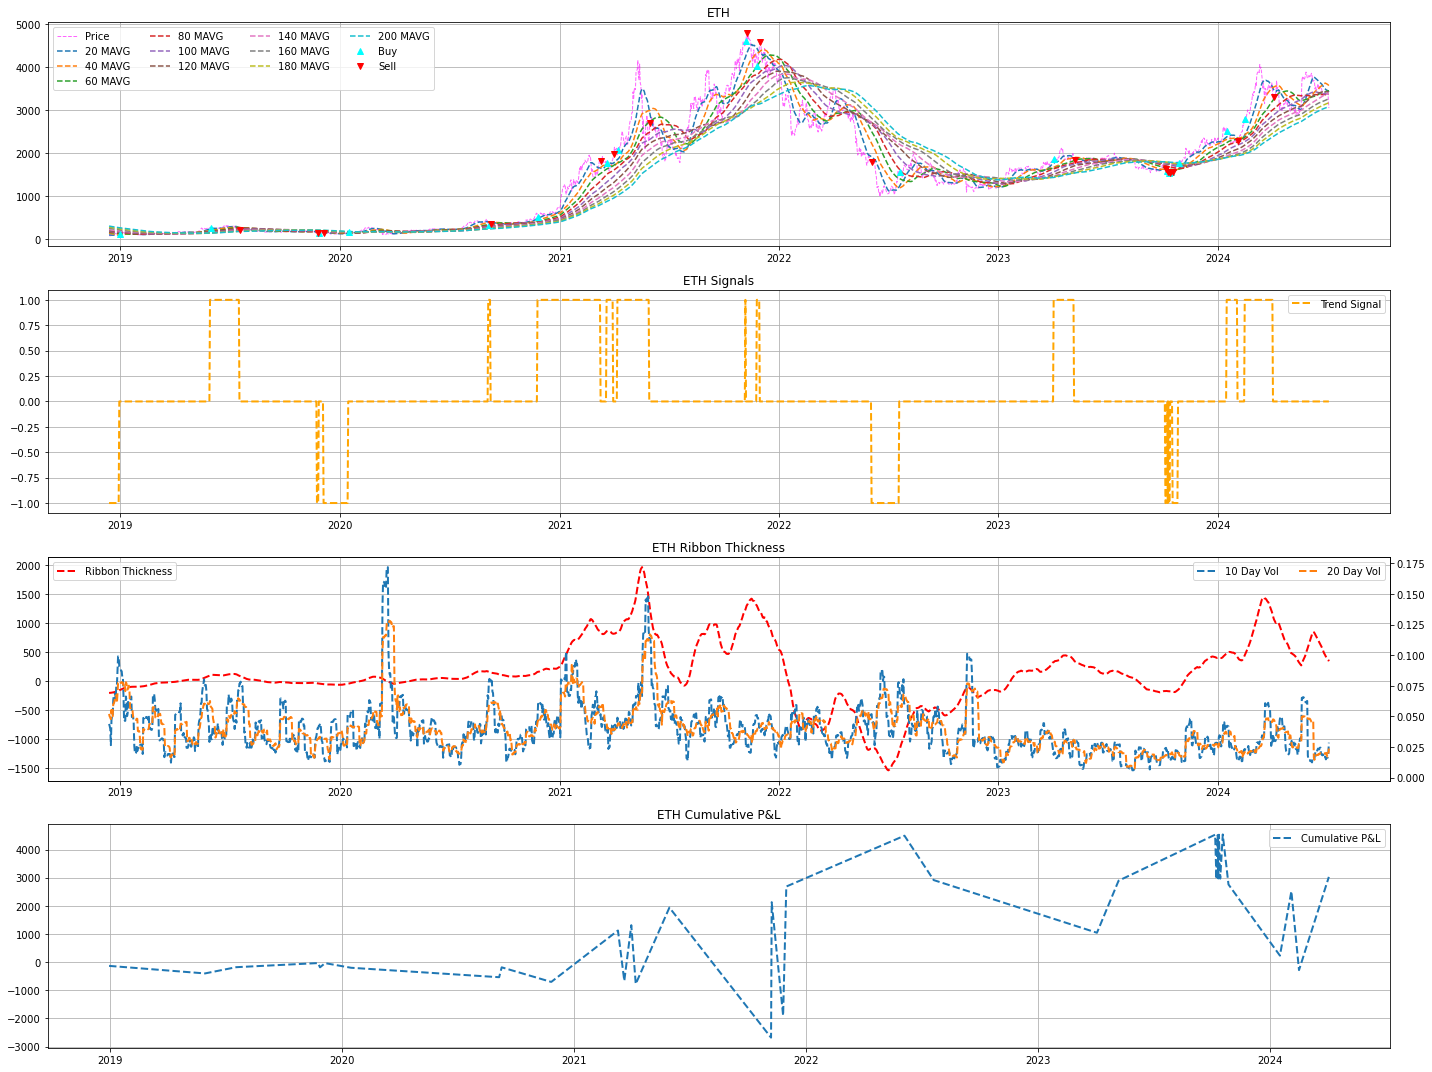

In [513]:
fig = plt.figure(figsize=(20,15))
# plt.style.use('bmh')
layout = (4,2)
mavg_ax = plt.subplot2grid(layout, (0,0), colspan=2)
ribbon_vol_ax = plt.subplot2grid(layout, (2,0), colspan=2)
signal_ax = plt.subplot2grid(layout, (1,0), colspan=2)
pnl_ax = plt.subplot2grid(layout, (3,0), colspan=2)
# trade_ax = plt.subplot2grid(layout, (1,1))

# _ = mavg_ax.plot(data.index, data['ETH-USD_short_mavg'], label='Short MAVG', linestyle='--', color='blue')
# _ = mavg_ax.plot(data.index, data['ETH-USD_long_mavg'], label='Long MAVG', linestyle='--', color='orange')
# _ = ribbon_ax.plot(data.index, data['ETH-USD_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='magenta', linewidth=2)
_ = mavg_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta', linewidth=1, alpha=0.6)
for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
    _ = mavg_ax.plot(data.index, data[f'ETH-USD_{int(window)}_mavg'], label=f'{int(window)} MAVG', linestyle='--')
    
buy_cond = (data['ETH-USD_trend_signal_diff'] == 1)
sell_cond = (data['ETH-USD_trend_signal_diff'] == -1)
_ = mavg_ax.plot(data[buy_cond].index, data[buy_cond]['ETH-USD_trend_trade'], label='Buy', linestyle='', color='cyan', linewidth=50, marker='^')
_ = mavg_ax.plot(data[sell_cond].index, data[sell_cond]['ETH-USD_trend_trade'], label='Sell', linestyle='', color='red', linewidth=50, marker='v')
    
# _ = slope_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta', linewidth=2, alpha=0.6)
# slope_ax2 = slope_ax.twinx()
# for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
#     _ = slope_ax2.plot(data.index, data[f'ETH-USD_{window}_mavg_slope'], label=f'{window} MAVG Slope', linestyle='--')

_ = signal_ax.plot(data.index, data['ETH-USD_trend_signal'], label='Trend Signal', linestyle='--', color='orange', linewidth=2)
# _ = signal_ax.plot(data.index, data['ETH-USD_trend_slope_signal'], label='Trend Slope Signal', linestyle='--', color='green', linewidth=2)#, marker='v')

_ = ribbon_vol_ax.plot(data.index, data['ETH-USD_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red', linewidth=2)
ribbon_vol_ax2 = ribbon_vol_ax.twinx()
_ = ribbon_vol_ax2.plot(data.index, data['ETH-USD_volatility_10'], label='10 Day Vol', linestyle='--', linewidth=2)
_ = ribbon_vol_ax2.plot(data.index, data['ETH-USD_volatility_20'], label='20 Day Vol', linestyle='--', linewidth=2)

pnl_cond = (data['ETH-USD_trend_trade'].notnull())
_ = pnl_ax.plot(data[pnl_cond].index, data[pnl_cond]['ETH-USD_mavg_trend_PnL_cum'], label='Cumulative P&L', linestyle='--', linewidth=2)

# _ = trade_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta', linewidth=2)
# buy_cond = (data['ETH-USD_trend_slope_signal'] == 1)
# sell_cond = (data['ETH-USD_trend_slope_signal'] == -1)
# _ = slope_ax.plot(data[buy_cond].index, data[buy_cond]['ETH-USD_trend_slope_trade'], label='Buy', linestyle='', color='red', linewidth=25, marker='^')
# _ = slope_ax.plot(data[sell_cond].index, data[sell_cond]['ETH-USD_trend_slope_trade'], label='Sell', linestyle='', color='green', linewidth=25, marker='v')

_ = mavg_ax.grid()
_ = mavg_ax.legend(ncol=4)
_ = mavg_ax.set_title('ETH')

# _ = slope_ax.grid()
# _ = slope_ax.legend(ncol=4, loc='upper left')
# _ = slope_ax2.legend(ncol=4, loc='upper right')
# _ = slope_ax.set_title('ETH Trend Signal')

_ = signal_ax.grid()
_ = signal_ax.legend(ncol=4)
_ = signal_ax.set_title('ETH Signals')

_ = ribbon_vol_ax.grid()
_ = ribbon_vol_ax.legend(ncol=4)
_ = ribbon_vol_ax.legend(ncol=4, loc='upper left')
_ = ribbon_vol_ax2.legend(ncol=4, loc='upper right')
_ = ribbon_vol_ax.set_title('ETH Ribbon Thickness')

_ = pnl_ax.grid()
_ = pnl_ax.legend(ncol=4)
_ = pnl_ax.set_title('ETH Cumulative P&L')

plt.tight_layout()

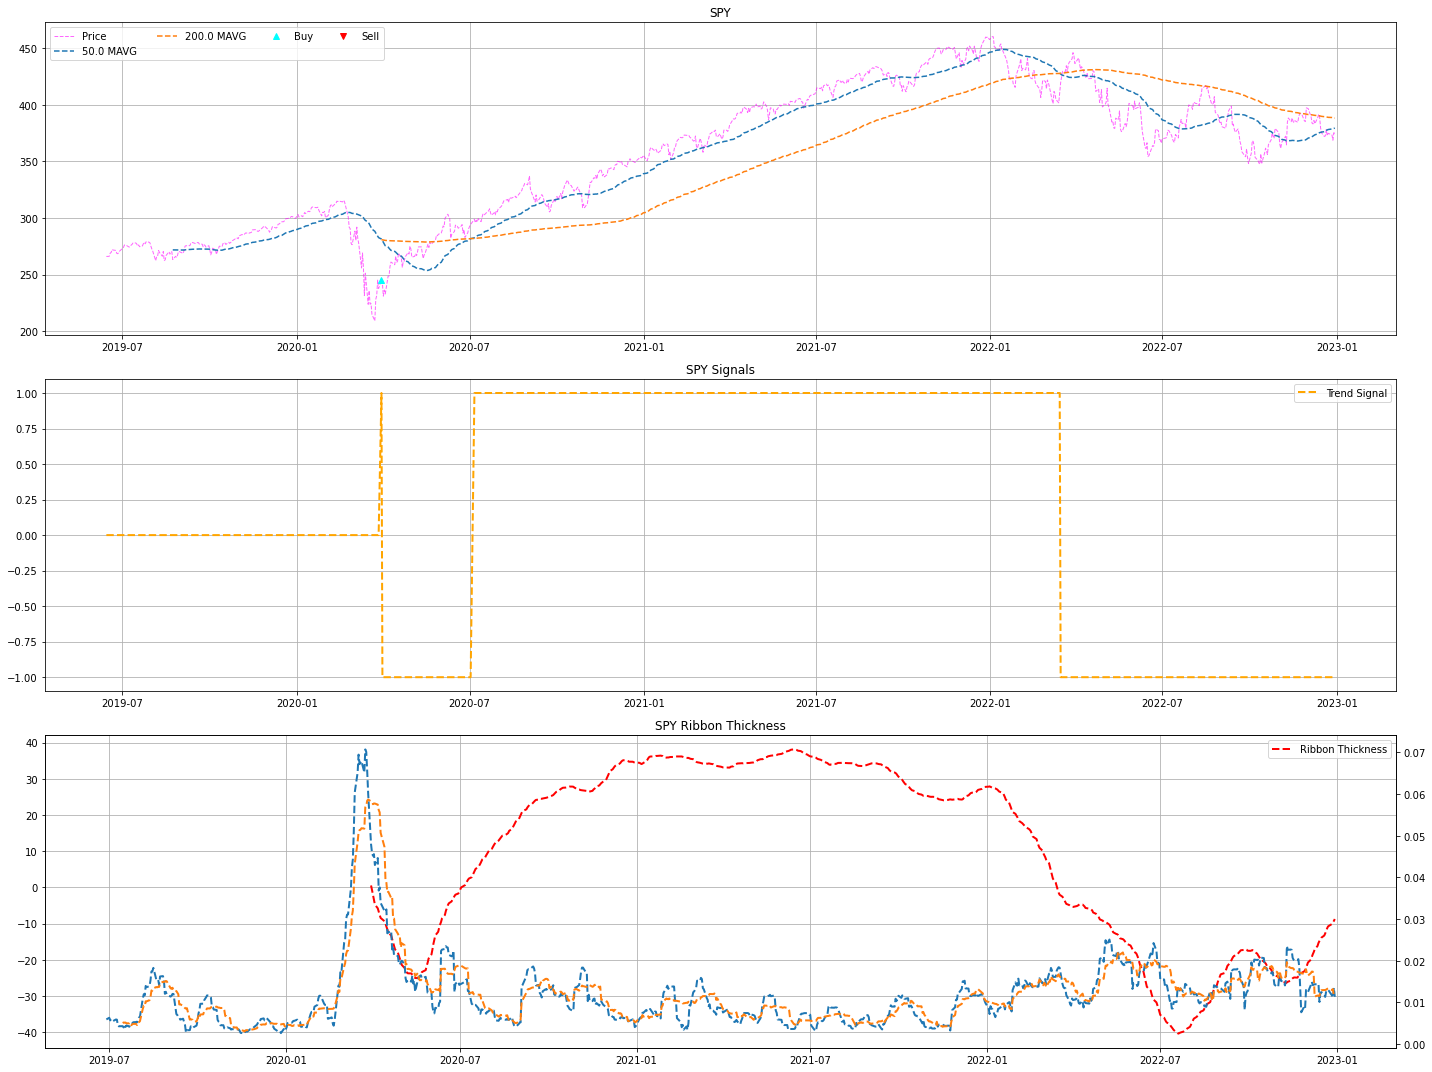

In [378]:
fig = plt.figure(figsize=(20,15))
# plt.style.use('bmh')
layout = (3,2)
mavg_ax = plt.subplot2grid(layout, (0,0), colspan=2)
ribbon_vol_ax = plt.subplot2grid(layout, (2,0), colspan=2)
signal_ax = plt.subplot2grid(layout, (1,0), colspan=2)
# trade_ax = plt.subplot2grid(layout, (1,1))

# _ = mavg_ax.plot(data_SPY.index, data_SPY['SPY_short_mavg'], label='Short MAVG', linestyle='--', color='blue')
# _ = mavg_ax.plot(data_SPY.index, data_SPY['SPY_long_mavg'], label='Long MAVG', linestyle='--', color='orange')
# _ = ribbon_ax.plot(data_SPY.index, data_SPY['SPY_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='magenta', linewidth=2)
_ = mavg_ax.plot(data_SPY.index, data_SPY['SPY'], label='Price', linestyle='--', color='magenta', linewidth=1, alpha=0.6)
for window in np.linspace(mavg_start_SPY, mavg_end_SPY, mavg_stepsize_SPY):
    _ = mavg_ax.plot(data_SPY.index, data_SPY[f'SPY_{window}_mavg'], label=f'{window} MAVG', linestyle='--')
    
buy_cond = (data_SPY['SPY_trend_signal_diff'] == 1)
sell_cond = (data_SPY['SPY_trend_signal_diff'] == -1)
_ = mavg_ax.plot(data_SPY[buy_cond].index, data_SPY[buy_cond]['SPY_trend_trade'], label='Buy', linestyle='', color='cyan', linewidth=50, marker='^')
_ = mavg_ax.plot(data_SPY[sell_cond].index, data_SPY[sell_cond]['SPY_trend_trade'], label='Sell', linestyle='', color='red', linewidth=50, marker='v')
    
# _ = slope_ax.plot(data_SPY.index, data_SPY['SPY'], label='Price', linestyle='--', color='magenta', linewidth=2, alpha=0.6)
# slope_ax2 = slope_ax.twinx()
# for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
#     _ = slope_ax2.plot(data_SPY.index, data_SPY[f'SPY_{window}_mavg_slope'], label=f'{window} MAVG Slope', linestyle='--')

_ = signal_ax.plot(data_SPY.index, data_SPY['SPY_trend_signal'], label='Trend Signal', linestyle='--', color='orange', linewidth=2)
# _ = signal_ax.plot(data_SPY.index, data_SPY['SPY_trend_slope_signal'], label='Trend Slope Signal', linestyle='--', color='green', linewidth=2)#, marker='v')

_ = ribbon_vol_ax.plot(data_SPY.index, data_SPY['SPY_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red', linewidth=2)
ribbon_vol_ax2 = ribbon_vol_ax.twinx()
_ = ribbon_vol_ax2.plot(data_SPY.index, data_SPY['SPY_volatility_10'], label='10 Day Vol', linestyle='--', linewidth=2)
_ = ribbon_vol_ax2.plot(data_SPY.index, data_SPY['SPY_volatility_20'], label='20 Day Vol', linestyle='--', linewidth=2)

# _ = trade_ax.plot(data_SPY.index, data_SPY['SPY'], label='Price', linestyle='--', color='magenta', linewidth=2)
# buy_cond = (data_SPY['SPY_trend_slope_signal'] == 1)
# sell_cond = (data_SPY['SPY_trend_slope_signal'] == -1)
# _ = slope_ax.plot(data_SPY[buy_cond].index, data_SPY[buy_cond]['SPY_trend_slope_trade'], label='Buy', linestyle='', color='red', linewidth=25, marker='^')
# _ = slope_ax.plot(data_SPY[sell_cond].index, data_SPY[sell_cond]['SPY_trend_slope_trade'], label='Sell', linestyle='', color='green', linewidth=25, marker='v')

_ = mavg_ax.grid()
_ = mavg_ax.legend(ncol=4)
_ = mavg_ax.set_title('SPY')

_ = slope_ax.grid()
_ = slope_ax.legend(ncol=4, loc='upper left')
_ = slope_ax2.legend(ncol=4, loc='upper right')
_ = slope_ax.set_title('SPY Trend Signal')

_ = signal_ax.grid()
_ = signal_ax.legend(ncol=4)
_ = signal_ax.set_title('SPY Signals')

_ = ribbon_vol_ax.grid()
_ = ribbon_vol_ax.legend(ncol=4)
_ = ribbon_vol_ax.set_title('SPY Ribbon Thickness')

plt.tight_layout()

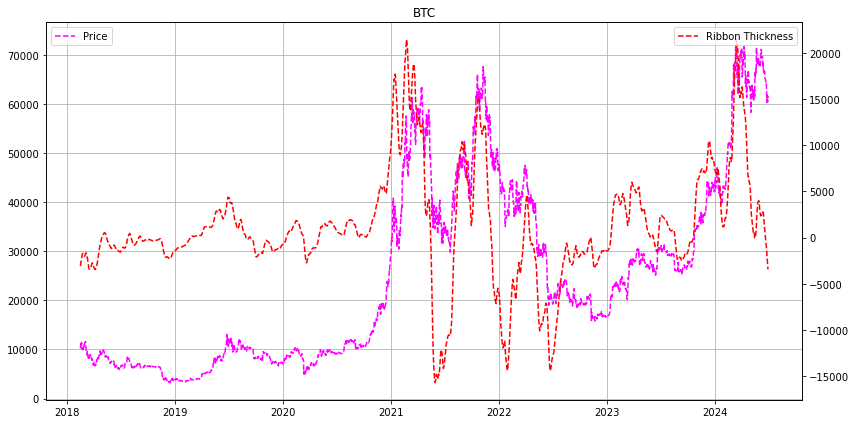

In [96]:
fig = plt.figure(figsize=(12,6))
# plt.style.use('bmh')
layout = (1,1)
mavg_ax = plt.subplot2grid(layout, (0,0))

_ = mavg_ax.plot(data.index, data['BTC-USD'], label='Price', linestyle='--', color='magenta')
mavg_ax2 = mavg_ax.twinx()
_ = mavg_ax2.plot(data.index, data['BTC_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red')
# for window in np.linspace(10, 100, 10):
#     _ = mavg_ax.plot(data.index, data[f'BTC_{window}_mavg'], label=f'{window} MAVG', linestyle='--')

_ = mavg_ax.grid()
_ = mavg_ax.legend(loc='upper left')
_ = mavg_ax2.legend(loc='upper right')
_ = mavg_ax.set_title('BTC')

plt.tight_layout()

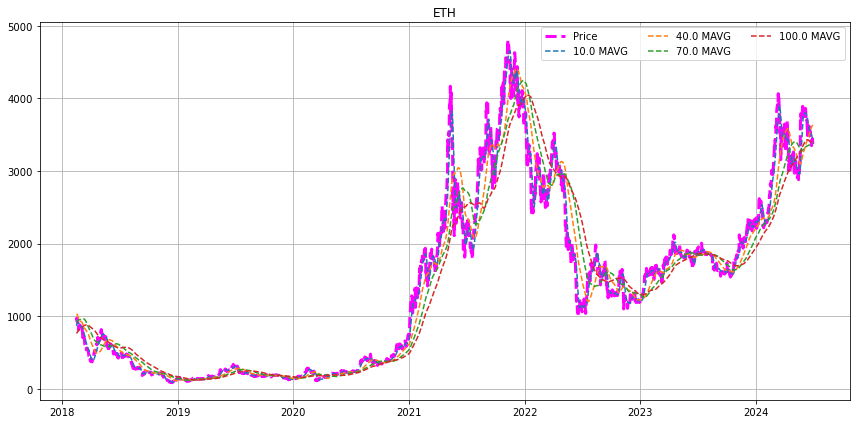

In [97]:
fig = plt.figure(figsize=(12,6))
# plt.style.use('bmh')
layout = (1,1)
mavg_ax = plt.subplot2grid(layout, (0,0))

# _ = mavg_ax.plot(data.index, data['BTC_short_mavg'], label='Short MAVG', linestyle='--', color='blue')
# _ = mavg_ax.plot(data.index, data['BTC_long_mavg'], label='Long MAVG', linestyle='--', color='orange')
_ = mavg_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta', linewidth=3)
for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
    _ = mavg_ax.plot(data.index, data[f'ETH_{window}_mavg'], label=f'{window} MAVG', linestyle='--')

_ = mavg_ax.grid()
_ = mavg_ax.legend(ncol=3)
_ = mavg_ax.set_title('ETH')

plt.tight_layout()

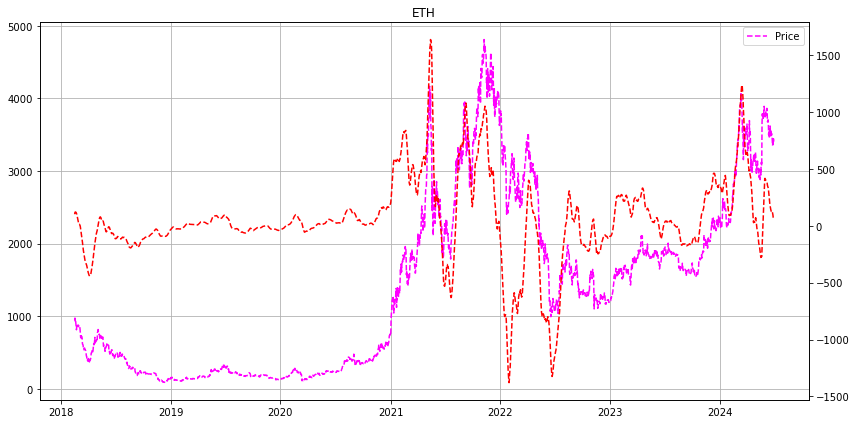

In [98]:
fig = plt.figure(figsize=(12,6))
# plt.style.use('bmh')
layout = (1,1)
mavg_ax = plt.subplot2grid(layout, (0,0))

_ = mavg_ax.plot(data.index, data['ETH-USD'], label='Price', linestyle='--', color='magenta')
mavg_ax2 = mavg_ax.twinx()
_ = mavg_ax2.plot(data.index, data['ETH_ribbon_thickness'], label='Ribbon Thickness', linestyle='--', color='red')
# for window in np.linspace(10, 100, 10):
#     _ = mavg_ax.plot(data.index, data[f'BTC_{window}_mavg'], label=f'{window} MAVG', linestyle='--')

_ = mavg_ax.grid()
_ = mavg_ax.legend()
_ = mavg_ax.set_title('ETH')

plt.tight_layout()

In [ ]:
col_list = [col for col in data.columns if (col[:3] == 'BTC') & (col[-4:] == 'mavg')]

In [ ]:
data[col_list].head()

In [ ]:
data.head()

In [ ]:
window_list = [window for window in np.linspace(10, 100, 10)]
for i in np.arange(len(window_list)-1):
    print(i, window_list[i], window_list[i+1])
    data[f'signal_{window_list[i]}_{window_list[i+1]}'] = np.where(data[f'BTC_{window_list[i]}_mavg'] >
                                                                  data[f'BTC_{window_list[i+1]}_mavg'], 1, 0)

In [ ]:
data.head(100)

In [ ]:
data['signal'] = np.where(data['BTC_short_mavg'] > data['BTC_long_mavg'], 1, -1)

In [ ]:
short_mavg = asset.rolling(window=30, center=False).mean()
long_mavg = asset.rolling(window=200, center=False).mean()

asset[200:].plot(figsize=(15,7))
short_mavg[200:].plot()
long_mavg[200:].plot()
plt.ylabel('Price')
plt.show()